In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import tqdm
import time
import datetime

import torch
import sklearn.metrics

# from qiskit_finance.data_providers import YahooDataProvider

import dimod

from neal.sampler import SimulatedAnnealingSampler
from tabu import TabuSampler

from dwave.system.composites import CutOffComposite

%run ../modules/portfolio.ipynb
%run ../modules/trainer.ipynb
%run ../modules/qubo.ipynb
%run ../modules/fm.ipynb
# %run ../modules/ortools.ipynb

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=10)

### 1) Portfolio - Dataset

In [2]:
# Generate Portfolio Dataset

PORTFOLIOS_COUNT = 100000
ASSETS_COUNT = 30

SP_500_PATH = '../finance/datasets/sp_500.xlsx'
DATA_FOLDER = '../finance/datasets/01/'

START_DATE = datetime.datetime(2021, 9, 26)
END_DATE = datetime.datetime(2022, 9, 26)

# START_DATE = datetime.datetime(2021, 10, 1)
# END_DATE = datetime.datetime(2021, 10, 10)

# START_DATE = datetime.datetime(2019, 9, 26)
# END_DATE = datetime.datetime(2020, 9, 26)

ASSET_PRICES_PATH = DATA_FOLDER + 'asset_prices.csv'

sp_500 = pd.read_excel(SP_500_PATH)

symbols = sp_500['Symbol'].to_list()[:ASSETS_COUNT]

if 'CEG' in symbols:
    symbols.remove('CEG')
    symbols.append('NVDA')

# symbols = ['NFLX', 'AAPL', 'META', 'GOOG', 'TSLA', 'AMZN', 'MSFT', 'NVDA']

# portfolios = np.random.randint(0, 2, size=(PORTFOLIOS_COUNT * 2, ASSETS_COUNT))
# portfolios = np.unique(portfolios, axis=0)[:PORTFOLIOS_COUNT]

portfolios = np.random.randint(0, 2, size=(PORTFOLIOS_COUNT, ASSETS_COUNT))

maximum_portfolios = 2 ** ASSETS_COUNT

dataset_coverage = PORTFOLIOS_COUNT / maximum_portfolios

print('maximum_portfolios:', maximum_portfolios)
print('portfolios_count:', PORTFOLIOS_COUNT)
print('dataset_coverage:', dataset_coverage)
print('portfolios.shape:', portfolios.shape)

maximum_portfolios: 1073741824
portfolios_count: 100000
dataset_coverage: 9.313225746154785e-05
portfolios.shape: (100000, 30)


In [3]:
# # Get stock data

# yahoo_provider = YahooDataProvider(tickers=symbols, start=START_DATE, end=END_DATE)

# yahoo_provider.run()

# tickers = yahoo_provider._tickers
# asset_prices = pd.concat(yahoo_provider._data, axis=1, keys=tickers)

In [4]:
# # Save asset prices

# asset_prices.to_csv(ASSET_PRICES_PATH, index=True)

In [5]:
# Load asset prices

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()

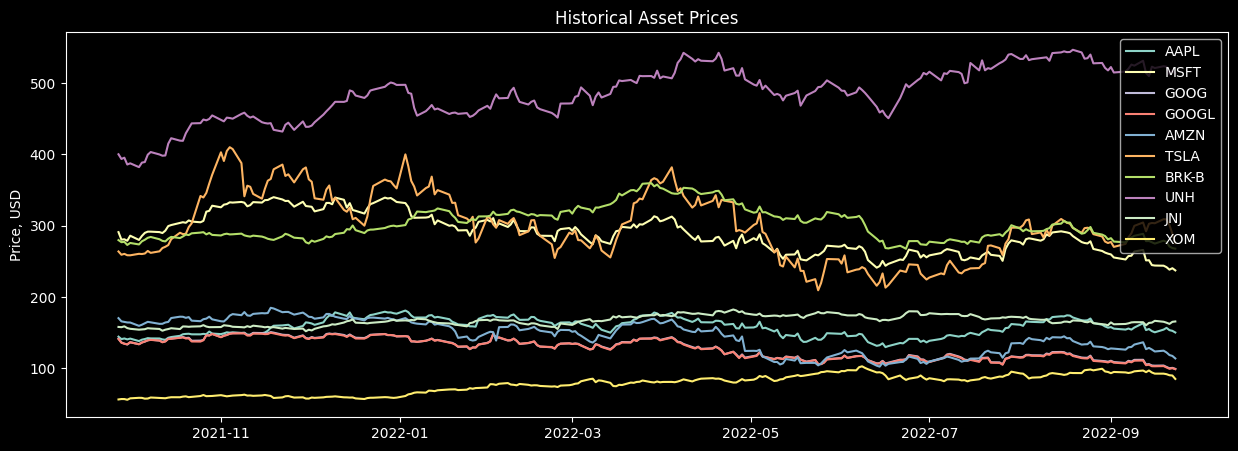

In [6]:
# Plot asset columns
MAX_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers)

plt.title("Historical Asset Prices")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

In [7]:
# Create Sharpe Dataset

sharpe_dataset = PortfolioDataset()

sharpe_dataset.load_portfolios(portfolios=portfolios,
                               asset_prices=asset_prices)

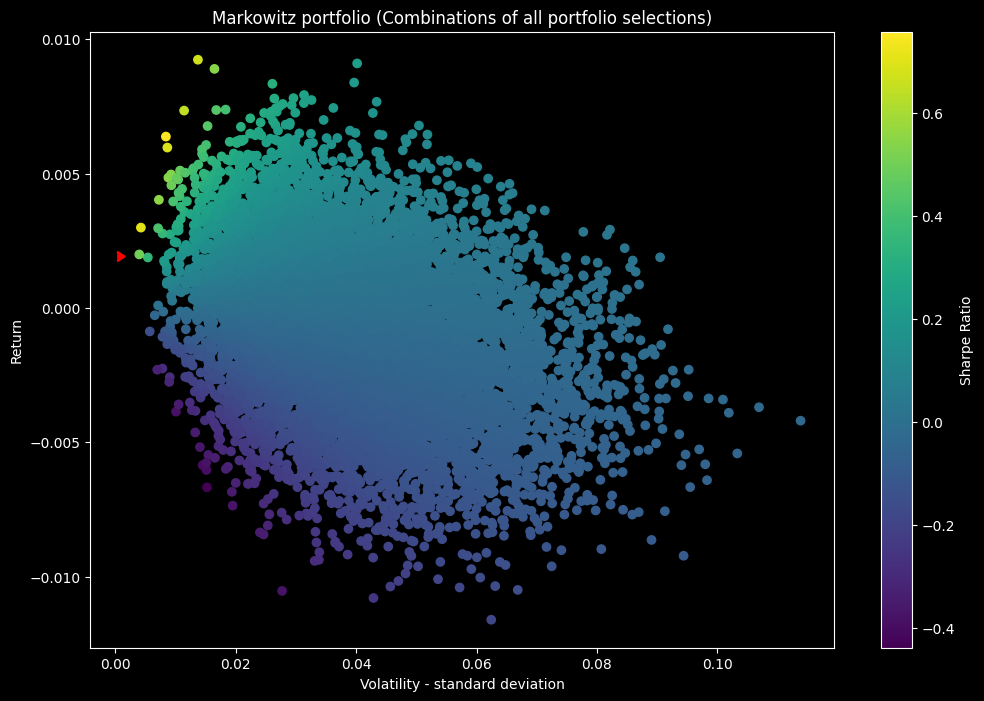

In [8]:
sharpe_dataset.plot_scatter(samples_to_plot=10000)

In [9]:
# sharpe_dataset.plot_histogram()

In [10]:
# Save Sharpe dataset

sharpe_dataset.save(DATA_FOLDER)

In [11]:
sharpe_dataset.data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,risk,return,sharpe
0,1,1,1,1,1,1,1,0,0,1,...,1,0,0,1,1,1,0,0.057731,0.000047,0.000822


### 2) FMQA Loop - Simulated Annealing

#### One Hot FMQA Loop

In [12]:
# FMQA Intialization

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

initial_dataset_sharpe = dataset.targets

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

updated_dataset.field_dimensions: (30,)


Iteration 1/5
splitter.lengths: (80000, 10000, 10000)


Epoch: 1/1: 100%|█████████████████████████████████████████████████| 80.0k/80.0k [00:01<00:00, 44.3k records/s]

Train r2_score: -1.56
Test  r2_score: -1.64


new_targets.max(): 0.87
dataset.targets.max(): 1.31
initial_dataset_sharpe.max(): 1.31
Iteration 2/5
splitter.lengths: (88000, 11000, 11000)


Epoch: 1/1: 100%|█████████████████████████████████████████████████| 88.0k/88.0k [00:01<00:00, 77.4k records/s]

Train r2_score: 0.95
Test  r2_score: 0.95


new_targets.max(): 1.89
dataset.targets.max(): 1.89
initial_dataset_sharpe.max(): 1.31
Iteration 3/5
splitter.lengths: (96000, 12000, 12000)


Epoch: 1/1: 100%|█████████████████████████████████████████████████| 96.0k/96.0k [00:01<00:00, 82.0k records/s]

Train r2_score: 0.97
Test  r2_score: 0.97


new_targets.max(): 2.48
dataset.targets.max(): 2.48
initial_dataset_sharpe.max(): 1.31
Iteration 4/5
splitter.lengths: (104000, 13000, 13000)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 104k/104k [00:01<00:00, 66.8k records/s]

Train r2_score: 0.97
Test  r2_score: 0.97


new_targets.max(): 3.54
dataset.targets.max(): 3.54
initial_dataset_sharpe.max(): 1.31
Iteration 5/5
splitter.lengths: (112000, 14000, 14000)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 112k/112k [00:01<00:00, 79.3k records/s]

Train r2_score: 0.97
Test  r2_score: 0.97


new_targets.max(): 4.69
dataset.targets.max(): 4.69
initial_dataset_sharpe.max(): 1.31


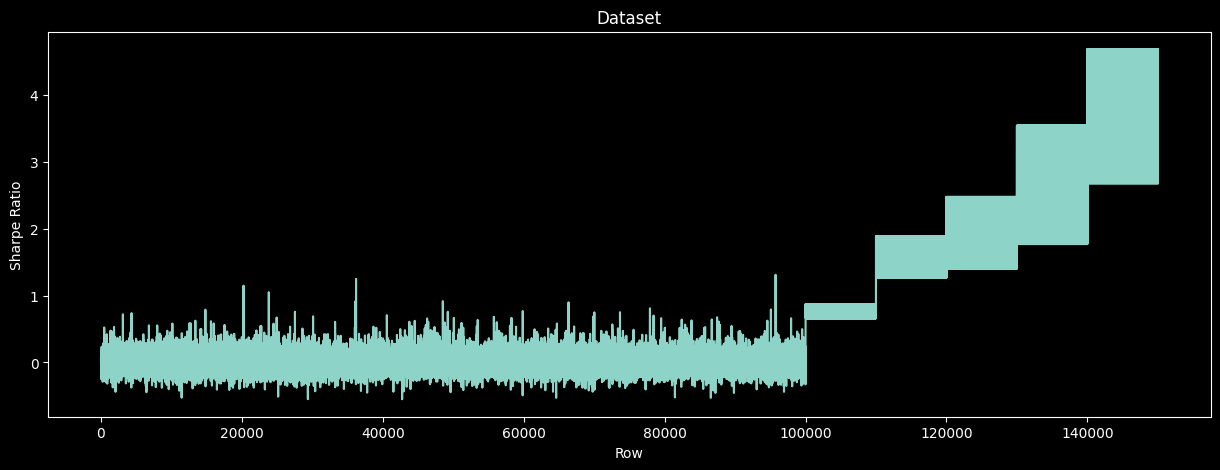

In [13]:
# FMQA Iteration

ITERATIONS_COUNT = 5

INITIAL_EPOCHS_COUNT = 1
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

SHOTS_COUNT = 100
PENALTY_VALUE = 10
MAXIMIZE = True

# SAMPLER = SimulatedAnnealingSampler()
# SAMPLER = ORToolsSampler()
SAMPLER = TabuSampler()
# SAMPLER = CutOffComposite(TabuSampler(), cutoff=0.01)

ORTOOLS_TIME_LIMIT = 10

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(dataset, batch_size=100,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    epochs_count = INITIAL_EPOCHS_COUNT if total_iteration == 1 else EPOCHS_COUNT
    
    trainer.train(epochs=epochs_count, 
                  validate=False)

    qubo = OneHotQubo(trainer=trainer,
                      penalty_value=PENALTY_VALUE,
                      maximize=MAXIMIZE)

    sampling_results = SAMPLER.sample_qubo(Q=qubo.qubo_coefficients, 
                                           num_reads=SHOTS_COUNT,
                                           time_limit=ORTOOLS_TIME_LIMIT)
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

    results = portfolio_decode_sampling_results(filtered_results)
    
    
    # New data
    
    new_fields, new_targets = portfolio_get_top_results(results, top_size=TOP_SIZE)
    
   
    # Append to Dataset
    
    dataset.append_records(new_fields, new_targets, SAMPLE_REPETITIONS_COUNT)
    
    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")        
        
plot_dataset()
# plot_samples()
# plot_top_samples()
# plot_sharpe_convergence()
# plot_dataset_histograms()

#### Top Portfolio

In [14]:
# Load asset prices

ASSET_PRICES_PATH = '../finance/datasets/01/asset_prices.csv'

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()


# Top results

top_result = results.sort_values('sharpe', ascending=False).head(1)

top_portfolio = top_result.portfolio.item().astype(bool)

top_prices = asset_prices.iloc[:, top_portfolio]

top_tickers = top_prices.columns.to_numpy().squeeze()

print(f"top_sharpe: {top_result.sharpe.item():.02f}")
print("top_portfolio:", top_portfolio.astype(int))
print("top_tickers:", top_tickers)

top_sharpe: 4.69
top_portfolio: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
top_tickers: LLY


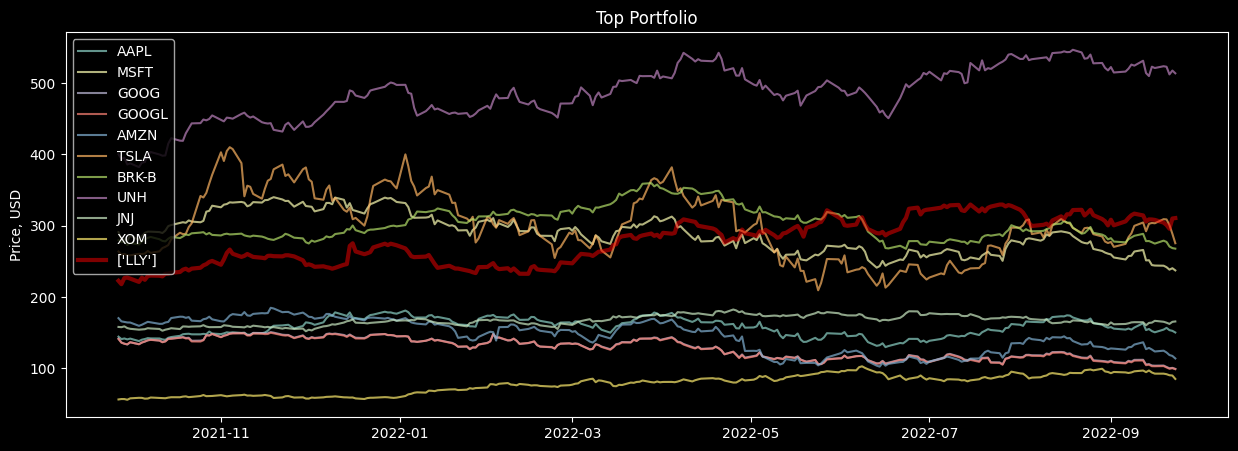

In [15]:
# Plot Top Portfolio

MAX_TICKERS = 10
MAX_TOP_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

if top_tickers.shape == ():    
    top_tickers = top_tickers.reshape(-1, 1)

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers,
         alpha=0.7)

# plt.gca().set_prop_cycle(color='rgbcmy')
plt.gca().set_prop_cycle(color='r')

plt.plot(top_prices.iloc[:, :MAX_TOP_TICKERS], 
         label=top_tickers[:MAX_TOP_TICKERS],
         # label=top_tickers,
         linewidth=3,
         alpha=0.5)

plt.title("Top Portfolio")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

### 3) Portfolio Monte-Carlo

In [16]:
dataset = PortfolioDataset()
dataset.load(DATA_FOLDER)

initial_dataset_sharpe = dataset.targets

sharpe_mins = []
sharpe_maxs = []
sharpe_means = []

total_iteration = 0

Iteration 1/10
new_targets.max(): 1.83
dataset.targets.max(): 1.83
initial_dataset_sharpe.max(): 1.31
Iteration 2/10
new_targets.max(): 2.76
dataset.targets.max(): 2.76
initial_dataset_sharpe.max(): 1.31
Iteration 3/10
new_targets.max(): 1.68
dataset.targets.max(): 2.76
initial_dataset_sharpe.max(): 1.31
Iteration 4/10
new_targets.max(): 1.81
dataset.targets.max(): 2.76
initial_dataset_sharpe.max(): 1.31
Iteration 5/10
new_targets.max(): 1.78
dataset.targets.max(): 2.76
initial_dataset_sharpe.max(): 1.31
Iteration 6/10
new_targets.max(): 3.56
dataset.targets.max(): 3.56
initial_dataset_sharpe.max(): 1.31
Iteration 7/10
new_targets.max(): 1.67
dataset.targets.max(): 3.56
initial_dataset_sharpe.max(): 1.31
Iteration 8/10
new_targets.max(): 1.83
dataset.targets.max(): 3.56
initial_dataset_sharpe.max(): 1.31
Iteration 9/10
new_targets.max(): 1.45
dataset.targets.max(): 3.56
initial_dataset_sharpe.max(): 1.31
Iteration 10/10
new_targets.max(): 2.41
dataset.targets.max(): 3.56
initial_datase

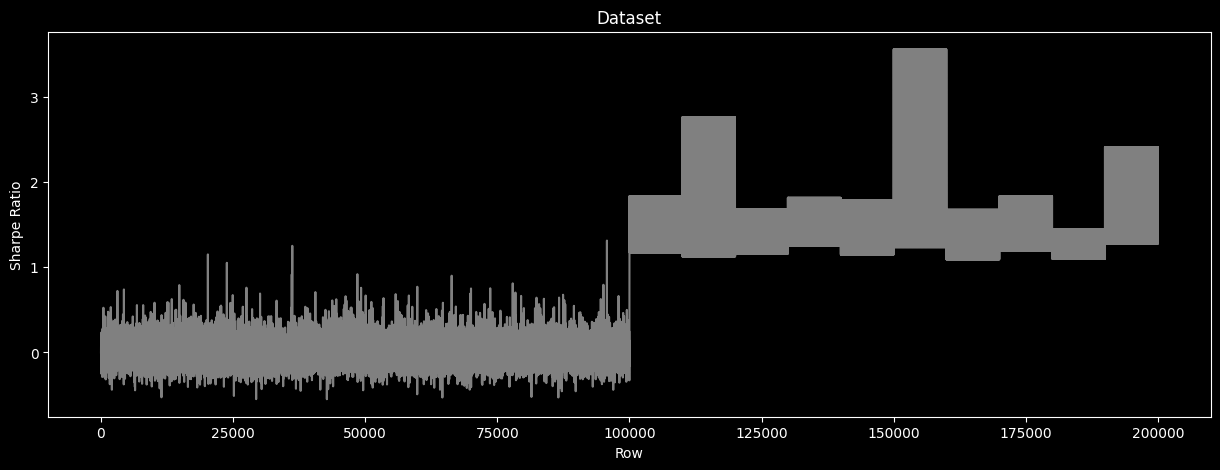

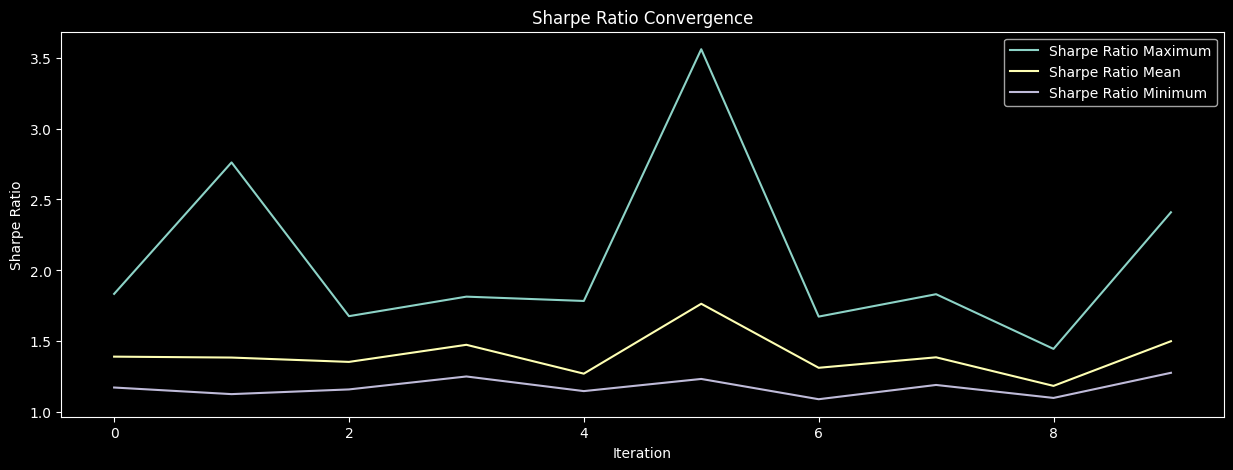

In [17]:
ITERATIONS_COUNT = 10
MC_SAMPLES_COUNT = 1000000

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

ASSETS_COUNT = dataset.fields.shape[1]

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    portfolios = np.random.randint(0, 2, size=(MC_SAMPLES_COUNT, ASSETS_COUNT))
    
    results = pd.DataFrame(portfolios)
    
    results['sharpe'] = dataset.sharpe.get_sharpe(portfolios, dataset.sigma, dataset.mu)
    
    top_results = results.sort_values('sharpe', ascending=False)[:TOP_SIZE]

    new_fields = top_results.iloc[:, :ASSETS_COUNT]

    new_targets = top_results.sharpe.to_numpy()
       
    
    # Append to Dataset
    
    new_rows_count = new_fields.shape[0] * SAMPLE_REPETITIONS_COUNT
    
    new_fields_array = np.tile(new_fields, (SAMPLE_REPETITIONS_COUNT, 1))
    new_targets_array = np.tile(new_targets, (SAMPLE_REPETITIONS_COUNT, 1)).ravel()
    
    dataset.fields = np.vstack((dataset.fields, new_fields_array))
    dataset.targets = np.concatenate((dataset.targets, new_targets_array)) 
    
    
    # Sharpe Dynamics
    
    max_sharpe = new_targets.max()
    mean_sharpe = new_targets.mean()
    min_sharpe = new_targets.min()
    
    sharpe_maxs.append(max_sharpe)    
    sharpe_means.append(mean_sharpe)
    sharpe_mins.append(min_sharpe)

    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")
    
    if max_sharpe == mean_sharpe == min_sharpe:
        
        print("Converged:", mean_sharpe)
        break
        

plt.figure(figsize=(15, 5))
plt.title("Dataset")
plt.xlabel("Row")
plt.ylabel("Sharpe Ratio")

plt.plot(dataset.targets,
         # color='C7',
         color='grey')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(sharpe_maxs, label="Sharpe Ratio Maximum")
plt.plot(sharpe_means, label="Sharpe Ratio Mean")
plt.plot(sharpe_mins, label="Sharpe Ratio Minimum")

plt.title("Sharpe Ratio Convergence")
plt.xlabel("Iteration")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()

### 4) Standalone FMQA

#### FM

In [18]:
DATA_FOLDER = '../finance/datasets/01/'

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

print("dataset.field_dimensions:", dataset.field_dimensions)
# print(dataset.data.head())
# dataset.plot_scatter()
print("Splitter lengths:", splitter.lengths) 

dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Splitter lengths: (80000, 10000, 10000)


In [33]:
trainer.train(epochs=3, validate=False)

Epoch: 3/3: 100%|███████████████████████████████████████████████████| 160k/160k [00:01<00:00, 87.7k records/s]

Train r2_score: 0.86
Test  r2_score: 0.86


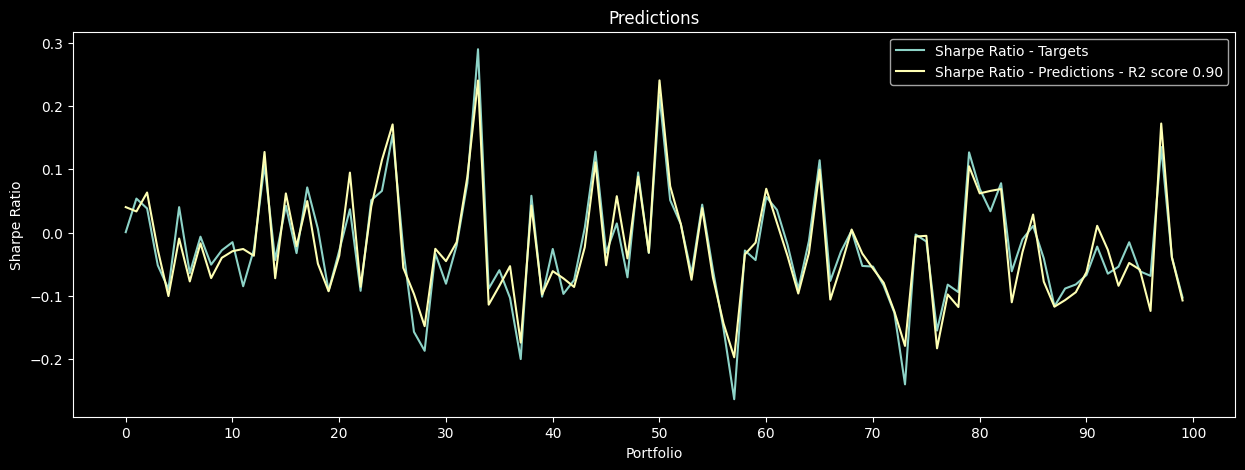

In [34]:
# Predict

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)

r2_score = sklearn.metrics.r2_score(targets, predictions)

# Plot

plt.figure(figsize=(15, 5))

plt.plot(targets, label=f"Sharpe Ratio - Targets")
plt.plot(predictions, label=f"Sharpe Ratio - Predictions - R2 score {r2_score:.02f}")

plt.locator_params(axis='x', nbins=20)

plt.title("Predictions")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

plt.show()

#### QUBO

In [35]:
PENALTY_VALUE = 1

MAXIMIZE = True

SHOTS_COUNT = 1000

qubo = OneHotQubo(trainer=trainer,
                  penalty_value=PENALTY_VALUE,
                  maximize=MAXIMIZE)

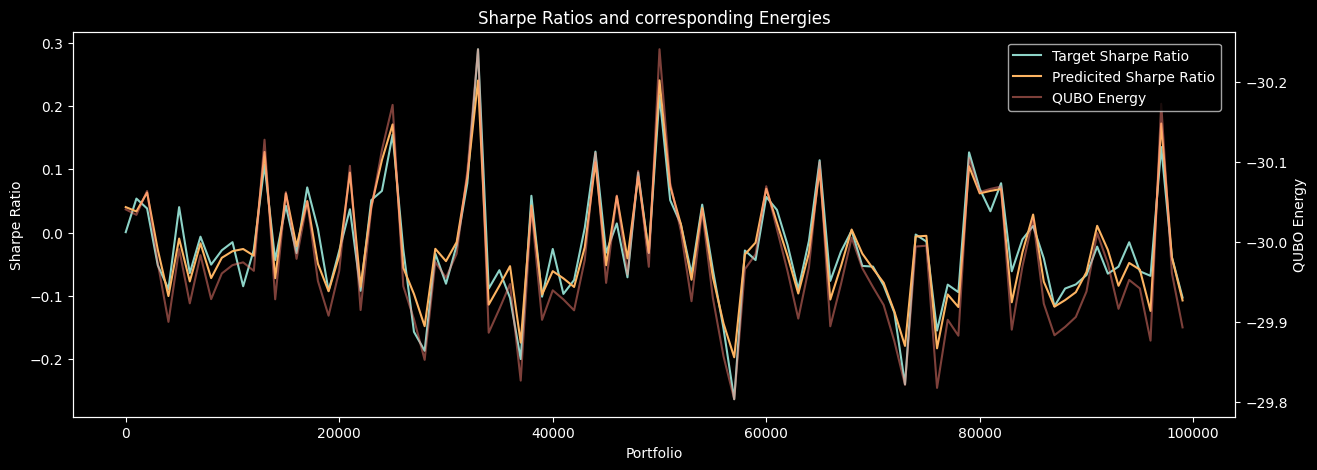

In [36]:
# QUBO Energies

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)


# Energies

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []


for row_bits in dataset.fields[indices]:
    
    one_hot_row = qubo.bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))

    energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo.qubo_coefficients)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)

    
# Predictions

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)


# General Plot

figure, data_ax = plt.subplots(figsize=(15, 5))
energy_ax = data_ax.twinx()

data_ax.plot(indices, targets, label="Target Sharpe Ratio")
data_ax.plot(indices, predictions, label="Predicited Sharpe Ratio", color='#fdb462')
energy_ax.plot(indices, energies, label="QUBO Energy", color='#fa8174', alpha=0.5)
# energy_ax.plot(indices, bqm_energies, label="BQM Energy", color='r')

energy_ax.invert_yaxis()

plt.title('Sharpe Ratios and corresponding Energies')
data_ax.set_xlabel("Portfolio")
data_ax.set_ylabel("Sharpe Ratio")
energy_ax.set_xlabel("Portfolio")
energy_ax.set_ylabel("QUBO Energy")

figure.legend(bbox_to_anchor=(0.895, 0.87))

plt.show()

#### Simulated Annealing

In [37]:
sampler = SimulatedAnnealingSampler()

# new_bqm = dimod.BinaryQuadraticModel(bqm.linear,
#                                      bqm.quadratic,
#                                      bqm.offset,
#                                      vartype=dimod.BINARY)

# spin_bqm = new_bqm.change_vartype(dimod.SPIN, inplace=False)


sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=SHOTS_COUNT)

# sampling_results = sampler.sample_qubo(Q=range_qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=excluded_qubo_coefficients, num_reads=shots_count)


# sampling_results = sampler.sample_ising(J=bqm.quadratic, h=bqm.linear, num_reads=shots_count)

# new_linear = {k[0]: v for k, v in qubo.qubo_coefficients.items() if k[0] == k[1]}

# sampling_results = sampler.sample_ising(J=qubo.qubo_coefficients, h=new_linear, num_reads=shots_count)

# sampling_results = sampler.sample(bqm=spin_bqm, num_reads=shots_count)

In [38]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

sampling_results: 1000
aggregated_results: 1000
filtered_results: 973


In [39]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)

    reversed_indices = np.arange(len(portfolio))[::-1]
    powers_of_two = 1 << reversed_indices
    decimal = portfolio.dot(powers_of_two)

    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

# pd.set_option('display.max_rows', 10)

# print("maximize:\n", MAXIMIZE)
# print("decoded_results.head:\n", decoded_results.head())

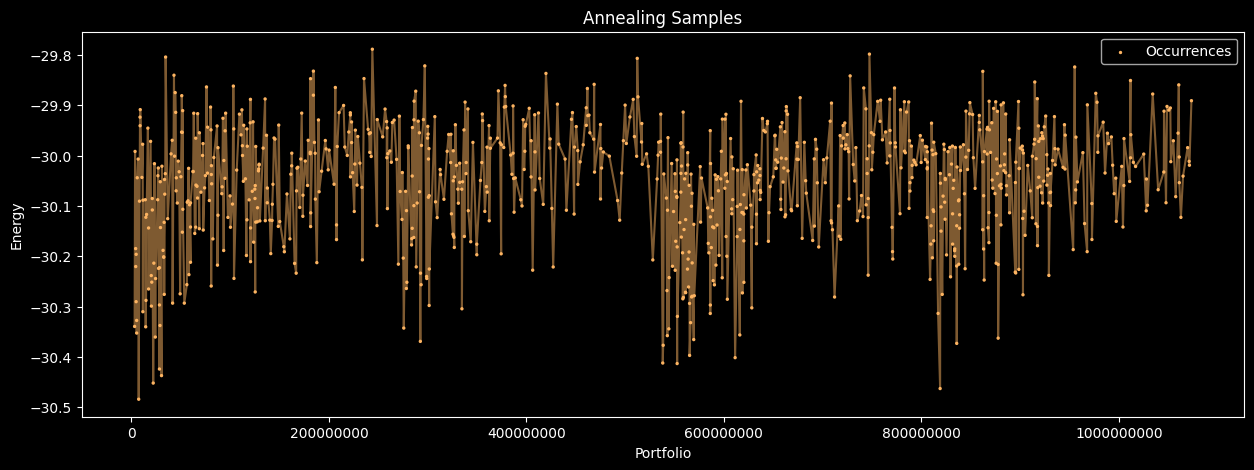

In [40]:
# Plot Samples

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1

plt.figure(figsize=(15, 5))

plt.plot(decimals, energies, 
         color='C5', 
         # color='C1', 
         alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            # color='C1', 
            s=sizes + 1)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Annealing Samples")
plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [41]:
# Sharpe Ratio Predictions for samples

trainer.model.eval()

portfolios_array = np.stack(results.portfolio).astype(int)

with torch.no_grad():

    predictions_for_samples = trainer.model(torch.tensor(portfolios_array))

predictions_for_samples

results['prediction'] = predictions_for_samples

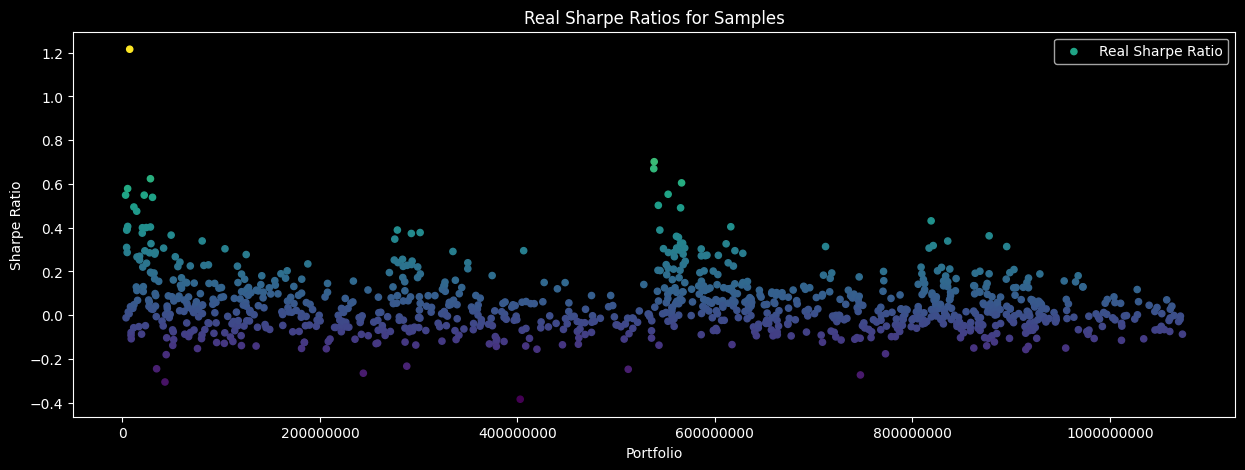

In [42]:
# Real Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.sharpe[::INDEX_STEP],
            c=results.sharpe[::INDEX_STEP],
            label="Real Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

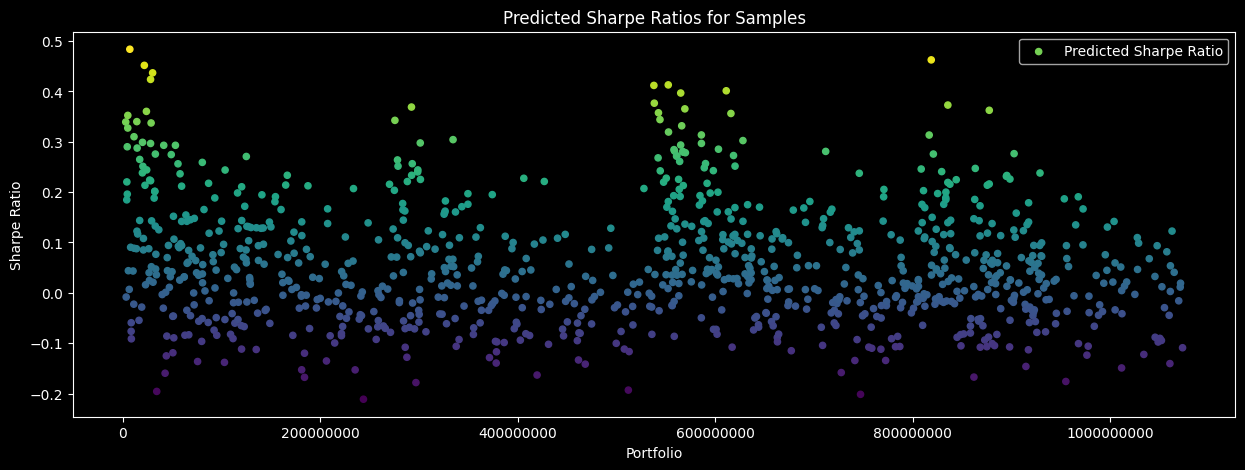

In [43]:
# Predicted Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.prediction[::INDEX_STEP],
            c=results.prediction[::INDEX_STEP],
            label="Predicted Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

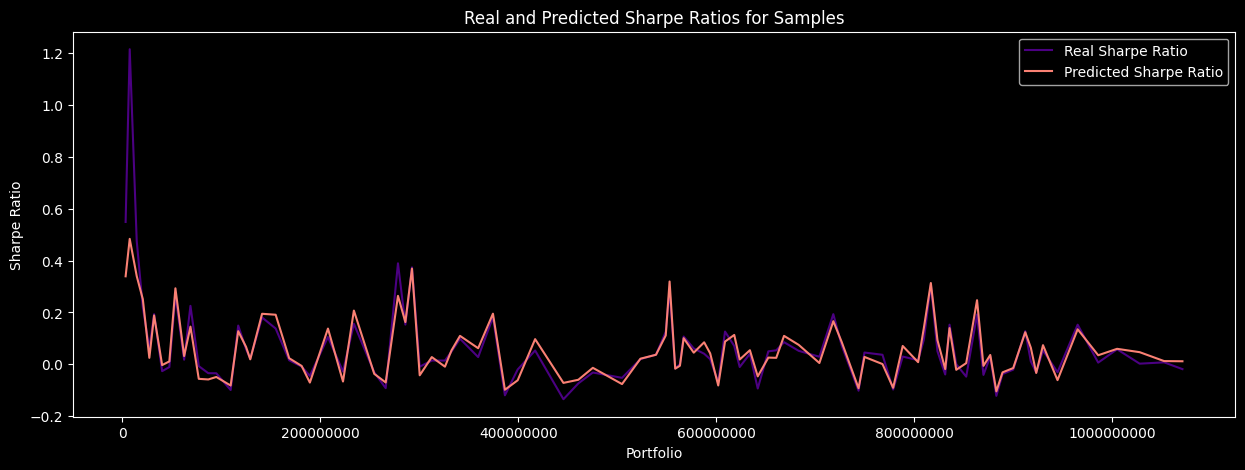

In [44]:
# Real and Predicted Sharpe Ratios for Samples

INDEX_STEP = 10

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo',
         label="Real Sharpe Ratio")
plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='C3',
         label="Predicted Sharpe Ratio")

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real and Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

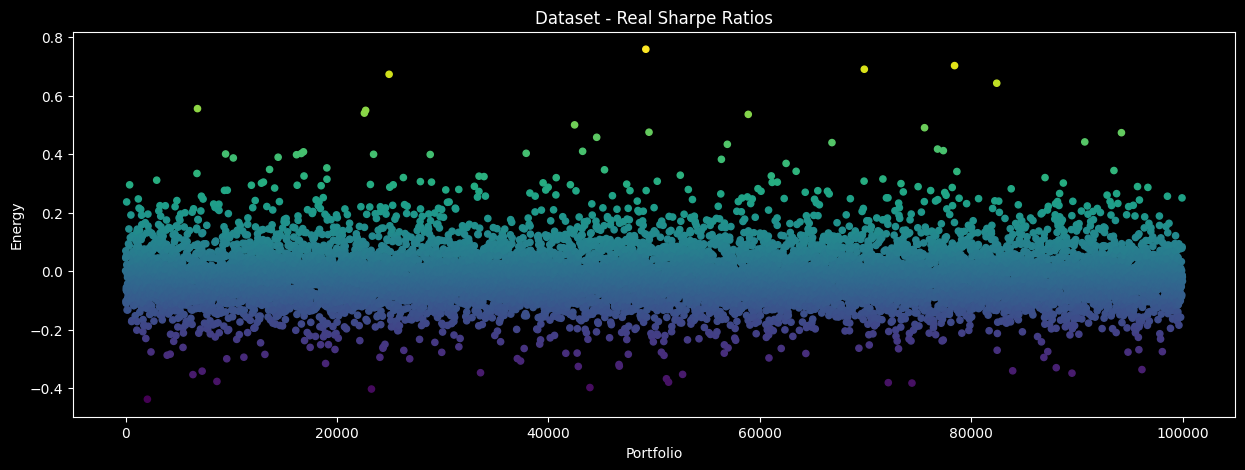

In [45]:
# Dataset Sharpe Ratios

INDEX_STEP = 10

plt.subplots(figsize=(15, 5))

plt.scatter(x=dataset.data.index[::INDEX_STEP],
            y=dataset.data.sharpe[::INDEX_STEP],
            c=dataset.data.sharpe[::INDEX_STEP], 
            s=20)

# plt.plot(results.decimal, results.energy, color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Dataset - Real Sharpe Ratios")
plt.xlabel("Portfolio")
plt.ylabel("Energy")

# plt.gca().invert_yaxis()

plt.show()

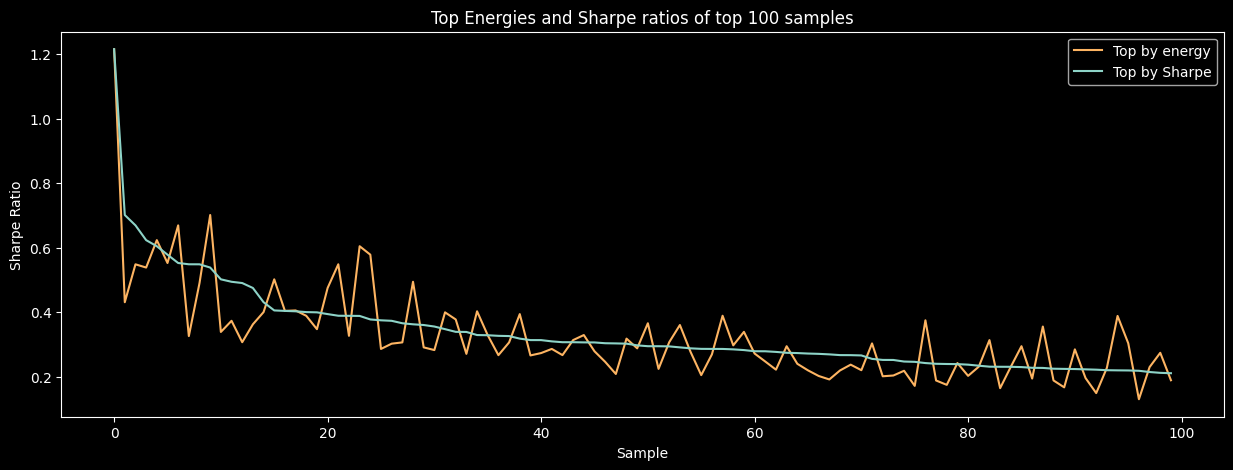

In [46]:
# Top Sharpes by Energy and by Sharpe

FIRST_PART = 100

results_by_energy = results.sort_values('energy', ascending=True)
results_by_sharpe = results.sort_values('sharpe', ascending=False)

plt.figure(figsize=(15, 5))
plt.plot(results_by_energy.index[:FIRST_PART], results_by_energy.sharpe[:FIRST_PART], label='Top by energy', c='C5')
plt.plot(results_by_energy.index[:FIRST_PART], results_by_sharpe.sharpe[:FIRST_PART], label='Top by Sharpe')

plt.title(f"Top Energies and Sharpe ratios of top {FIRST_PART} samples")
plt.xlabel("Sample")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()